In [370]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import trange, tqdm

from bprg.nerual import NeuralFunction
from bprg.operator import Operator
from bprg.kernel import KernelMesh


import seaborn as sns
import matplotlib.pyplot as plt

# Neural network approximation for fixpoint

In [2]:
DTYPE = 'float32'
# dicretize
ns = 1000
dx = 1/ns
S = [0,1]

K = 2 # thresholds
η = np.array([0.1, 0, 0.9]) # dv_k / dμ
μ = lambda x: x # Lebsgue measure
κ = lambda x,y : 10*tf.sqrt(x**2 + y**2) / (1+ tf.sqrt(tf.abs(x-y)))


In [340]:
op = Operator(S, ns, κ, K, μ, η)

fparams = {'operators': op}
class FixPoint(NeuralFunction):   
    def eval_errors(self, X, y):
        op = self.__dict__['operators']
        S = op.S_lin
        
        f_S = self(S) # vector of f on S
        f_X = self(X) # vector of f on x's        
        ψf_X = op.Ψ(f_S, X)
        
        err = ψf_X - f_X
        return [err]

### Remark: add a error to  minimize f 

In [346]:
nnfp = FixPoint([layers.Dense(20, activation='tanh', name='layer1', input_shape=(1,)),
                 layers.Dense(20, activation='tanh', name='layer2'),
                 layers.Dense(1, activation='tanh', name='output')],
                 fparams = fparams,
                )

# initialize optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.05, epsilon=1e-10)
# initialize callback for learning rate decay
callback_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss_total', factor=0.9, min_delta=1e-10)

nnfp.compile(optimizer=optimizer, loss='MAE')

In [347]:
S_train = op.S_lin
fake_y_train = tf.zeros_like(S_train, dtype=DTYPE)

In [348]:
nnfp.fit(S_train, fake_y_train,
         batch_size=None, epochs=500,
         verbose=False,
         callbacks=[callback_lr],)

In [349]:
f_S = nnfp(S_train)
ψf_S = op.Ψ(f_S, S_train)

df = pd.DataFrame({'s': S_train.numpy().flatten(),
                  'f': f_S.numpy().flatten(),
                  'Ψf': ψf_S.numpy().flatten()})
df_sns = df.melt(id_vars='s', value_vars=['f', 'Ψf'],
        var_name='function', value_name='value')

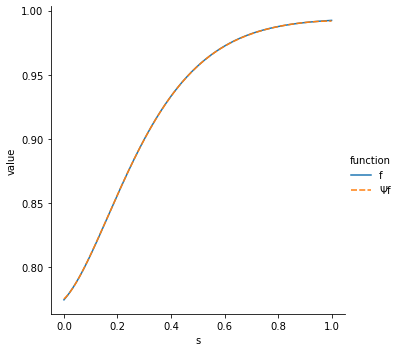

In [350]:
sns.relplot(data=df_sns, x='s', y='value',
            hue='function',
            style='function',
            kind='line')

# Simulate graphs

In [396]:
nv = (ns+1)*3
L = ns + 1
bprg = BPRG(nv, S, ns+1, K, κ, η)

M = 1000
kv_final_list = []
for m in trange(M):
    kv_final = bprg.simulate()['kv_list'][-1]
    kv_final_list.append(kv_final)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [12:15<00:00,  1.36it/s]


In [397]:
fL_list = [bprg.cal_infection_scale_by_type(kv)
           for kv in kv_final_list]

In [398]:
pd.DataFrame(fL_list).T.to_csv('fL_df.csv')

fL = np.array(fL_list).mean(axis=0)

df2 = df.copy()
df2['f_L'] = fL
df2_sns = df2.melt(id_vars='s', value_vars=['f', 'Ψf', 'f_L'],
        var_name='function', value_name='value')
df2.to_csv('function_value.csv')

In [406]:
df2

,s,f,Ψf,f_L
0,0.000,0.774559,0.775257,0.763667
1,0.001,0.774800,0.775438,0.790333
2,0.002,0.775044,0.775625,0.762000
3,0.003,0.775290,0.775819,0.774000
4,0.004,0.775538,0.776020,0.764000
...,...,...,...,...
996,0.996,0.992398,0.991909,0.990333
997,0.997,0.992410,0.991906,0.989667
998,0.998,0.992423,0.991902,0.991333
999,0.999,0.992435,0.991897,0.994000


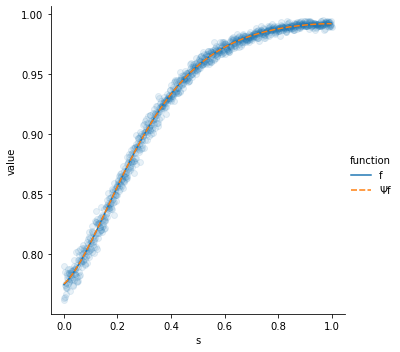

In [402]:
sns.relplot(data=df_sns, x='s', y='value',
            hue='function',
            style='function',
            kind='line')
plt.scatter(op.S_lin, fL, alpha=0.1)

# Simulation through n = 200 to 10000

In [381]:
nv_list = np.arange(200, 10001, 200)
M = 100
L = 100
pct_table = np.zeros((M, len(nv_list)))

In [382]:
%%time
for col, nv in enumerate(nv_list):
    bprg = BPRG(nv, S, L, K, κ, η)
    for row in tqdm(range(M), position=0, leave=False, desc='%s/%s, #%s vertices' % (col, len(nv_list) ,nv)):
        kv_fin = bprg.simulate()['kv_list'][-1]
        pct = (kv_fin == 0).mean()
        pct_table[row, col] = pct

CPU times: user 23h 53min 55s, sys: 3h 44min 59s, total: 1d 3h 38min 55s
Wall time: 4h 28min 15s


In [409]:
pct_table.shape

(100, 50)

In [411]:
pd.DataFrame(pct_table).T.to_csv('pct_

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.935000,0.925000,0.925000,0.910000,0.915000,0.945000,0.920000,0.955000,0.925000,0.960000,...,0.925000,0.915000,0.925000,0.965000,0.935000,0.880000,0.905000,0.905000,0.925000,0.925000
1,0.945000,0.915000,0.902500,0.910000,0.930000,0.922500,0.920000,0.905000,0.892500,0.937500,...,0.925000,0.937500,0.917500,0.932500,0.957500,0.935000,0.932500,0.937500,0.922500,0.930000
2,0.945000,0.933333,0.920000,0.921667,0.928333,0.940000,0.930000,0.908333,0.940000,0.918333,...,0.918333,0.931667,0.933333,0.940000,0.920000,0.926667,0.946667,0.935000,0.936667,0.918333
3,0.930000,0.922500,0.913750,0.926250,0.940000,0.930000,0.920000,0.921250,0.940000,0.931250,...,0.920000,0.917500,0.942500,0.936250,0.926250,0.931250,0.946250,0.922500,0.942500,0.937500
4,0.930000,0.926000,0.924000,0.925000,0.936000,0.937000,0.948000,0.928000,0.926000,0.924000,...,0.935000,0.923000,0.930000,0.918000,0.924000,0.926000,0.935000,0.940000,0.936000,0.931000
5,0.922500,0.925833,0.943333,0.922500,0.916667,0.929167,0.931667,0.917500,0.930000,0.910833,...,0.921667,0.922500,0.933333,0.915000,0.920000,0.930000,0.923333,0.945833,0.923333,0.942500
6,0.933571,0.932857,0.912857,0.933571,0.932857,0.932143,0.916429,0.921429,0.924286,0.920000,...,0.939286,0.927143,0.912857,0.937857,0.918571,0.932857,0.920000,0.932857,0.919286,0.938571
7,0.919375,0.930000,0.927500,0.923750,0.931250,0.939375,0.916250,0.926250,0.914375,0.919375,...,0.920625,0.933125,0.921875,0.925625,0.921250,0.928750,0.928125,0.930000,0.921250,0.934375
8,0.927778,0.926111,0.920556,0.926667,0.915000,0.936667,0.938889,0.918333,0.928333,0.925000,...,0.938889,0.925000,0.927222,0.910000,0.921667,0.922778,0.921111,0.928333,0.924444,0.933333
9,0.922500,0.919000,0.932000,0.936500,0.929000,0.916000,0.931500,0.911500,0.931500,0.917500,...,0.934000,0.920000,0.930000,0.922000,0.921000,0.927000,0.929000,0.927000,0.927500,0.916000


In [424]:
pct_df = pd.DataFrame(pct_table).T
pct_df.index = nv_list
idx = 'n'
pct_df.index.name = idx

In [427]:
pct_df.to_csv('data/infection_pct.csv')

In [433]:
pct_df = pd.DataFrame(pct_table).T
pct_df.index = nv_list
idx = 'n'
pct_df.index.name = idx
pct_df = pct_df.reset_index()
pct_df_melt = pct_df.melt(id_vars=idx)

In [434]:
pct_df_melt

,n,variable,value
0,200,0,0.935000
1,400,0,0.945000
2,600,0,0.945000
3,800,0,0.930000
4,1000,0,0.930000
...,...,...,...
4995,9200,99,0.926304
4996,9400,99,0.928936
4997,9600,99,0.926875
4998,9800,99,0.925408


<AxesSubplot:xlabel='n', ylabel='value'>

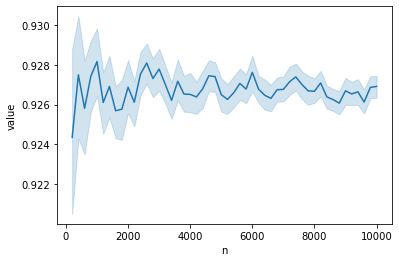

In [435]:
sns.lineplot(data=pct_df_melt, x=idx, y="value", ci=95)